In [1]:
import sys
from pathlib import Path

# Add src directory to path for imports
src_dir = Path("../src").resolve()
sys.path.insert(0, str(src_dir))

In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


In [3]:
from config import RAW_DATA_DIR

print(f"Data Directory: {RAW_DATA_DIR}")
print(f"Directory exists: {os.path.exists(RAW_DATA_DIR)}")

Data Directory: /home/eren/Coding/ml_projects/oasis-alz-classifier/data/raw
Directory exists: True


In [4]:
classes = sorted(os.listdir(RAW_DATA_DIR))
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

Number of classes: 4
Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [5]:
# Count images per class
image_counts = {
    cls: len(os.listdir(os.path.join(RAW_DATA_DIR, cls))) for cls in classes
}
total_images = sum(image_counts.values())

print(f"\nTotal images: {total_images:,}")
print("\nImages per class:")

# Print percentages
for cls, count in image_counts.items():
    percentage = (count / total_images) * 100
    print(f"  {cls}: {count:,} ({percentage:.2f}%)")



Total images: 86,437

Images per class:
  Mild Dementia: 5,002 (5.79%)
  Moderate Dementia: 488 (0.56%)
  Non Demented: 67,222 (77.77%)
  Very mild Dementia: 13,725 (15.88%)


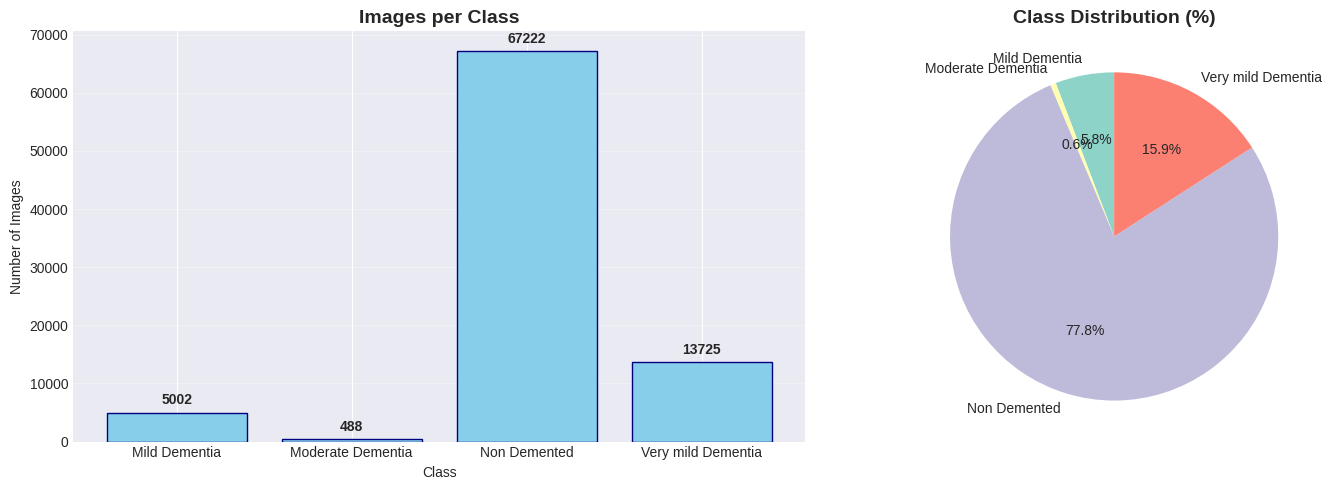


Class Imbalance Ratio: 137.75x
🤣 WARNING: Significant class imbalance detected!


In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(
    image_counts.keys(), image_counts.values(), color="skyblue", edgecolor="navy"
)
axes[0].set_title("Images per Class", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Number of Images")
axes[0].grid(axis="y", alpha=0.3)

# Add value labels on bars
for i, (cls, count) in enumerate(image_counts.items()):
    axes[0].text(
        i,
        count + total_images * 0.01,
        str(count),
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Pie chart
colors = plt.cm.Set3(range(len(classes)))
axes[1].pie(
    image_counts.values(),
    labels=image_counts.keys(),
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
)
axes[1].set_title("Class Distribution (%)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# Check for class imbalance
max_count = max(image_counts.values())
min_count = min(image_counts.values())
imbalance_ratio = max_count / min_count
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 3:
    print("🤣 WARNING: Significant class imbalance detected!")


In [7]:
def analyze_image_properties(data_dir, classes, sample_size=100):
    """Analyze dimensions, formats, and modes of images."""
    properties = {
        "class": [],
        "width": [],
        "height": [],
        "channels": [],
        "format": [],
        "mode": [],
        "aspect_ratio": [],
        "file_size_kb": [],
    }

    for cls in classes:
        folder = os.path.join(data_dir, cls)
        files = os.listdir(folder)
        sample = random.sample(files, min(sample_size, len(files)))

        for file in tqdm(sample, desc=f"Analyzing {cls}", leave=False):
            path = os.path.join(folder, file)
            try:
                img = Image.open(path)
                properties["class"].append(cls)
                properties["width"].append(img.width)
                properties["height"].append(img.height)
                properties["channels"].append(len(img.getbands()))
                properties["format"].append(img.format)
                properties["mode"].append(img.mode)
                properties["aspect_ratio"].append(img.width / img.height)
                properties["file_size_kb"].append(os.path.getsize(path) / 1024)
            except Exception as e:
                print(f"Error reading {path}: {e}")

    return pd.DataFrame(properties)


print("Analyzing image properties (this may take a few minutes)...")
df_props = analyze_image_properties(RAW_DATA_DIR, classes, sample_size=200)


Analyzing image properties (this may take a few minutes)...


Analyzing Mild Dementia:  60%|██████    | 121/200 [00:00<00:00, 1202.67it/s]

In [8]:
print("\n" + "=" * 60)
print("DIMENSION ANALYSIS")
print("=" * 60)

unique_dims = df_props.groupby(["width", "height", "channels"]).size().reset_index(name="count")
unique_dims = unique_dims.sort_values("count", ascending=False)

print(f"Number of unique dimensions: {len(unique_dims)}")
print("\nTop 5 most common dimensions:")
print(unique_dims.head())

if len(unique_dims) > 5:
    print("\n⚠️ WARNING: Multiple image dimensions detected!")
    print(
        "   Recommendation: Resize all images to a consistent size during preprocessing"
    )
    print(
        f"   Suggested size: {df_props['width'].mode()[0]}x{df_props['height'].mode()[0]}"
    )



DIMENSION ANALYSIS
Number of unique dimensions: 1

Top 5 most common dimensions:
   width  height  channels  count
0    496     248         3    800



Visualizing sample images...


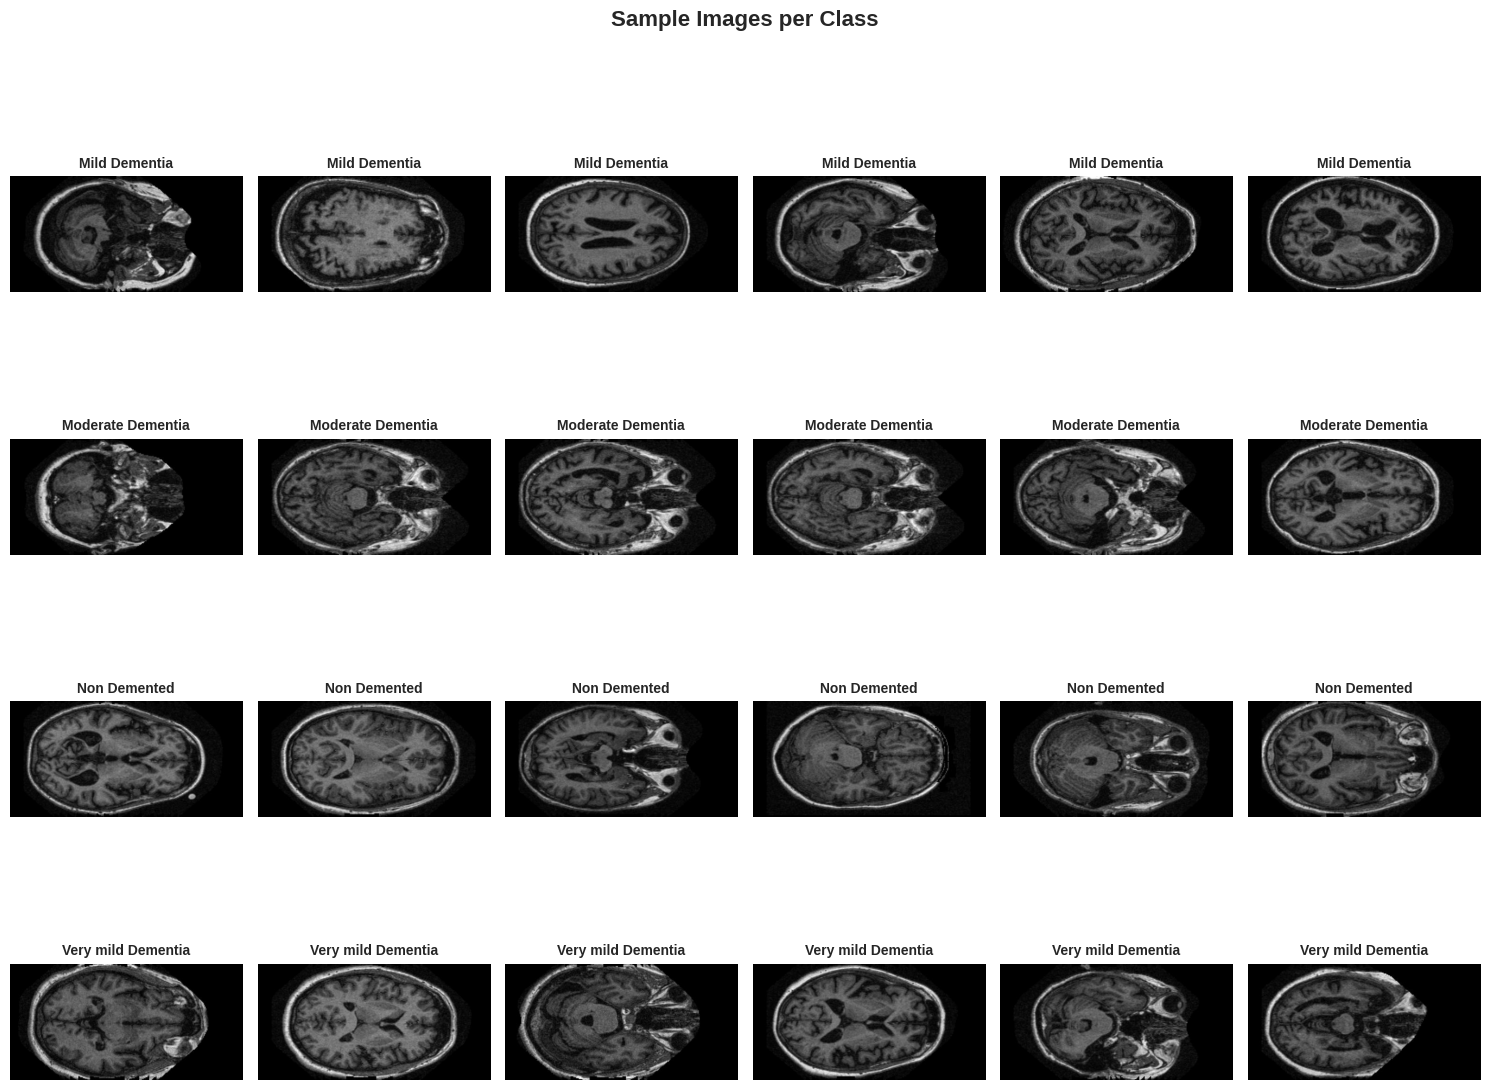

In [9]:
def visualize_samples(data_dir, classes, n_samples=5):
    """Visualize sample images from each class."""
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 3 * len(classes)))

    if len(classes) == 1:
        axes = axes.reshape(1, -1)

    for i, cls in enumerate(classes):
        folder = os.path.join(data_dir, cls)
        files = os.listdir(folder)
        sample = random.sample(files, min(n_samples, len(files)))

        for j, file in enumerate(sample):
            path = os.path.join(folder, file)
            try:
                img = Image.open(path)
                axes[i, j].imshow(img, cmap="gray")
                axes[i, j].set_title(f"{cls}", fontsize=10, fontweight="bold")
                axes[i, j].axis("off")
            except Exception as e:
                axes[i, j].text(
                    0.5,
                    0.5,
                    f"Error loading image",
                    ha="center",
                    va="center",
                    transform=axes[i, j].transAxes,
                )
                axes[i, j].axis("off")

    plt.suptitle("Sample Images per Class", fontsize=16, fontweight="bold", y=1.00)
    plt.tight_layout()
    plt.show()


print("\nVisualizing sample images...")
visualize_samples(RAW_DATA_DIR, classes, n_samples=6)
